<h1 align="center" style="font-family:serif;"><b>Segmentación de imágenes urbanas de un dron mediante Deep Learning</b></h1>
<h2 align="center" style="font-family:serif;">Trabajo Fin de Grado</h2>
<h2 align="center" style="font-family:serif;">Universidad de Valladolid</h2>
<h3 align="right" style="font-family:serif;"><b>Autor:</b> Carlos Martín Sanz</h3>
<h3 align="right" style="font-family:serif;"><b>Tutor:</b> Teodoro Calonge Cano</h3>

##  Imports

In [13]:
import nbimporter

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch
from torchsummary import summary
import torch.optim as optim

from sklearn.metrics import accuracy_score

import time

from torchvision.transforms import ToTensor

import numpy as np

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

## Tamaño del lote

In [14]:
# Tamaño del lote
tam_lote = 16

## Vemos si tenemos GPU

In [15]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [16]:
print(torch.__version__)

2.2.0.dev20231113


In [17]:
print(torch.version.cuda) 

12.1


In [18]:
!echo $CUDA_VISIBLE_DEVICES

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(device,"\n")

cpu 



## Run otros ipynb

In [61]:
# ipynb que contiene el entrenamiento de una epoca
%run notebooks/Train/train.ipynb

# ipynb que contiene el test de una epoca
%run notebooks/Test/test.ipynb

# ipynb que contiene el nombre de las clases y el diccionario de colores
%run ./colormap.ipynb

# ipynb que calcula las metricas del modelo
%run ./notebooks/Results/roc_treshold.ipynb

# ipynb que calcula las metricas del modelo
%run ./notebooks/DataLoad/count_classes.ipynb

In [21]:
from notebooks.DataLoad.DataLoader import UNetDataset
from notebooks.Model.unet import *

## Carga de imagenes, lotes y visualización

In [22]:
# Rutas hacia las imagenes
train_img_folder = 'notebooks/DataLoad/Definitivas/semantic_drone_dataset/train_imgs/original_images'
train_label_folder = 'notebooks/DataLoad/Definitivas/semantic_drone_dataset/train_imgs/label_images_semantic'
test_img_folder = 'notebooks/DataLoad/Definitivas/semantic_drone_dataset/test_imgs/original_images'
test_label_folder = 'notebooks/DataLoad/Definitivas/semantic_drone_dataset/test_imgs/label_images_semantic'

train_dataset = UNetDataset(train_img_folder, train_label_folder)
test_dataset = UNetDataset(test_img_folder, test_label_folder)

In [23]:
# Creacion de los lotes
train_loader = DataLoader(train_dataset, batch_size=tam_lote, shuffle=True, num_workers= 8)
test_loader = DataLoader(test_dataset, batch_size=tam_lote, shuffle=True, num_workers= 8)

In [12]:
# Vemos los lotes que tenemos
print("Tenemos ", len(train_loader), " lotes de ", tam_lote, " imágenes para train")
print("Tenemos ", len(test_loader), " lotes de ", tam_lote, " imágenes para test")

Tenemos  600  lotes de  16  imágenes para train
Tenemos  200  lotes de  16  imágenes para test


## Distribución de clases

In [63]:
conteo_train, porcentaje_train, total_train = contar_pixeles(train_loader, tam_lote)
conteo_test, porcentaje_test, total_test = contar_pixeles(test_loader, tam_lote)

### Distribución de clases para train

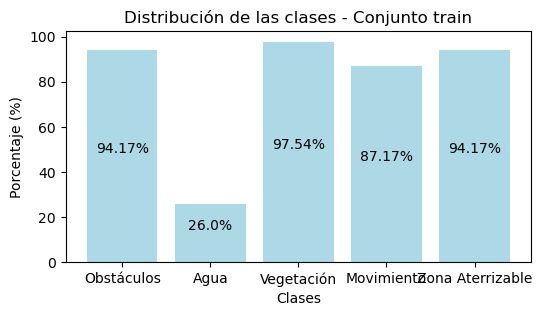

In [70]:
# Creamos el grafico para el conjunto de train

plt.figure(figsize=(6, 3))
barras = plt.bar(clases, porcentaje_train, color='lightblue')
plt.xlabel('Clases')
plt.ylabel('Porcentaje (%)')
plt.title('Distribución de las clases - Conjunto train')

# Añadimos las etiquetas en el medio de las barras
for barra in barras:
    yval = barra.get_height()
    
    # Colocamos el porcentaje en el centrode la barra
    plt.text(barra.get_x() + barra.get_width()/2, yval/2,  f'{round(yval, 2)}%', ha='center', va='bottom', color='black')
    
plt.show()

### Distribución de clases para test

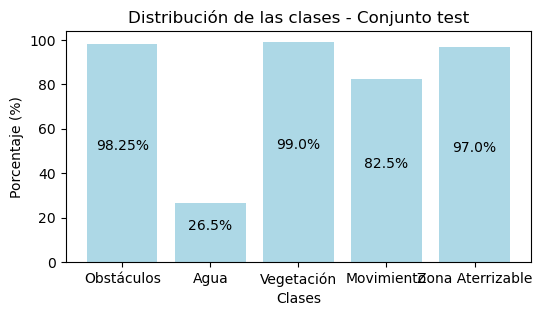

In [71]:
# Creamos el grafico para el conjunto de test

plt.figure(figsize=(6, 3))
barras = plt.bar(clases, porcentaje_test, color='lightblue')
plt.xlabel('Clases')
plt.ylabel('Porcentaje (%)')
plt.title('Distribución de las clases - Conjunto test')

# Añadimos las etiquetas en el medio de las barras
for barra in barras:
    yval = barra.get_height()
    
    # Colocamos el porcentaje en el centrode la barra
    plt.text(barra.get_x() + barra.get_width()/2, yval/2,  f'{round(yval, 2)}%', ha='center', va='bottom', color='black')
    
plt.show()

### Distribución de clases conjunto de datos completo

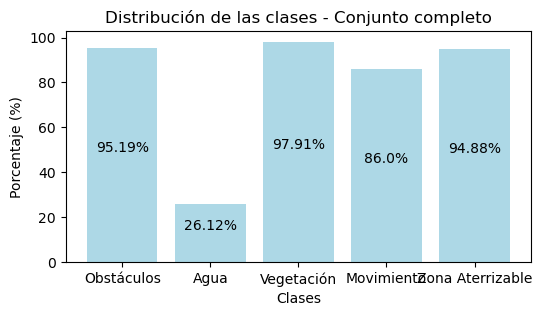

In [74]:
conteo_total = []

# Sumamos el conteo obtenido en el conjunto de test y train para tener el conteo del conjunto total
for i in range(len(conteo_train)):
    
    suma = conteo_train[i] + conteo_test[i]
    
    # Añadimos el resultado a la lista conteo_total
    conteo_total.append(suma)
    
imagenes_total = total_train + total_test

porcentaje_total = [round(conteo / imagenes_total * 100,2) for conteo in conteo_total]

plt.figure(figsize=(6, 3))
barras = plt.bar(clases, porcentaje_total, color='lightblue')
plt.xlabel('Clases')
plt.ylabel('Porcentaje (%)')
plt.title('Distribución de las clases - Conjunto completo')

# Añadimos las etiquetas en el medio de las barras
for barra in barras:
    yval = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2, yval/2,  f'{round(yval, 2)}%', ha='center', va='bottom', color='black')
    
plt.show()

# Modelo

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(device,"\n")

# Nº clases de salida son 5 los objetos a identificar: agua, vegetacion, obstaculo, movimiento y zona aterrizable
out_classes = 5

# U-NET Model build
unet_model = UNet(out_classes)

# Inicialización de pesos al modelo
unet_model.apply(init_weights)

# Movemos el modelo a la gpu
unet_model = unet_model.to(device)

cpu 



In [25]:
# Asume que 'modelo' es tu modelo de red neuronal
summary(unet_model, input_size = (3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
         LeakyReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
         LeakyReLU-6         [-1, 64, 256, 256]               0
         BlockConv-7         [-1, 64, 256, 256]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
 DownsamplingBlock-9  [[-1, 64, 128, 128], [-1, 64, 256, 256]]               0
           Conv2d-10        [-1, 128, 128, 128]          73,856
      BatchNorm2d-11        [-1, 128, 128, 128]             256
        LeakyReLU-12        [-1, 128, 128, 128]               0
           Conv2d-13        [-1, 128, 128, 128]         147,584
      BatchNorm2d-14    

In [16]:
# Nº de epocas
epochs = 55

# Nº iteraciones sin mejora hasta que pare
stop = 8       

# Tasa de aprendizaje
learning_rate = 0.001 

# Función de perdida
loss_crit = nn.CrossEntropyLoss() 

# Nº de épocas estancamiento para reducir el learning rate
patience = 2

# Optimizador
optm = optim.Adam(unet_model.parameters(), lr = learning_rate)

# Algoritmo Fine-Tuning
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optm, patience=patience, verbose=True)

## Parámetros de Train del modelo

In [17]:
print("Tamaño del lote:", tam_lote)
print("Número de épocas:", epochs)
print("Número de iteraciones sin mejora para que pare:", stop)
print("Tasa de aprendizaje:", learning_rate)
print("Función de pérdida:", loss_crit)
print("Optimizador: ", optm)
print("Scheduler: ", scheduler)

Tamaño del lote: 16
Número de épocas: 45
Número de iteraciones sin mejora para que pare: 8
Tasa de aprendizaje: 0.001
Función de pérdida: CrossEntropyLoss()
Optimizador:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Scheduler:  <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7f3a4e4c3cd0>


## Variables para almacenar los resultados del entrenamiento

In [18]:
train_acc = []      # Precision de entrenamiento
test_acc = []       # Precision de prueba
learning_rates = [] # Almacenamos los diferentes valores de la tasa de aprendizaje
total_losses = []   # Perdidas de todas iteracion

best_acc_val = 0
epoch_worst = 0
cont_epochs = 0

## Entrenamiento y Validación

In [20]:
t_ini = time.time()

for epoch in range(epochs):
    
    # Precision entrenamiento de la epoca
    train_loss, acc = train_unet(unet_model, train_loader, optm, loss_crit, device)
    
    lr_previo = optm.param_groups[0]['lr']
    
    # Obtenemos la perdida de la época
    perdida_media = sum(train_loss)/len(train_loss)
    
    print(f"La pérdida media de la época {epoch+1} es: {perdida_media}")
    scheduler.step(perdida_media)
    
    # Imprime el learning rate actual
    lr = scheduler.get_last_lr()[0]
    learning_rates.append(lr)
    
    # Imprimimos cuando mejoramos el learning rate
    if lr_previo != lr :
        print(f"  ~~ Adaptando Learning Rate ~~ Modificación de: {lr_previo - lr}")

    
    print(f"Época {epoch + 1}, Learning Rate: {lr:.6f}")
    
    # Añadimos las perdidas de esa época
    total_losses.extend(train_loss)
    
    # AÑadimos la precisión de la época
    train_acc.append(acc)
    print(f"Época {epoch + 1}, Precisión entrenamiento: {acc:.2f}")

    # Precisión validación
    acc_test = validate_unet(unet_model, test_loader, loss_crit, device)
    test_acc.append(acc_test)
    print(f"Época {epoch + 1}, Precisión validación: {acc_test:.2f}")
    
    # ~~~~~~~~~~~~~~~~~~ GUARDAMOS DEL MODELO ~~~~~~~~~~~~~~~~~~
    if acc_test > best_acc_val :
        best_acc_val = acc_test
        epoch_worst = 0
        
        # Guardamos el modelo
        torch.save(unet_model, "models/last_try.pth")
        print(" ~ GUARDANDO MODELO ~ Obtenemos una precisión = ", best_acc_val," %.")
    else:
        epoch_worst += 1
        
    cont_epochs += 1

    # ~~~~~~~~~~~~~~~~~~~~ EARLY STOPPING ~~~~~~~~~~~~~~~~~~
    if epoch_worst >= stop:
        print(" ~~ DETENCIÓN DEL ENTRENAMIENTO ~~ Van ", epoch_worst, " épocas sin obtener mejora.")
        break
        
t_fin = time.time()
print("\nEl tiempo de entrenamiento del modelo son: ", ((t_fin-t_ini)/60)/60, " horas")

La pérdida media de la época 1 es: 0.43090058689316113
Época 1, Learning Rate: 0.001000
Época 1, Precisión entrenamiento: 84.54
Época 1, Precisión validación: 85.91
 ~ GUARDANDO MODELO ~ Obtenemos una precisión =  85.91  %.
La pérdida media de la época 2 es: 0.354883798584342
Época 2, Learning Rate: 0.001000
Época 2, Precisión entrenamiento: 87.05
Época 2, Precisión validación: 87.77
 ~ GUARDANDO MODELO ~ Obtenemos una precisión =  87.77  %.
La pérdida media de la época 3 es: 0.3173475782573223
Época 3, Learning Rate: 0.001000
Época 3, Precisión entrenamiento: 88.41
Época 3, Precisión validación: 88.58
 ~ GUARDANDO MODELO ~ Obtenemos una precisión =  88.58  %.
La pérdida media de la época 4 es: 0.2830277338375648
Época 4, Learning Rate: 0.001000
Época 4, Precisión entrenamiento: 89.62
Época 4, Precisión validación: 89.02
 ~ GUARDANDO MODELO ~ Obtenemos una precisión =  89.02  %.
La pérdida media de la época 5 es: 0.2561692521472772
Época 5, Learning Rate: 0.001000
Época 5, Precisión en

## Evolución del learning rate

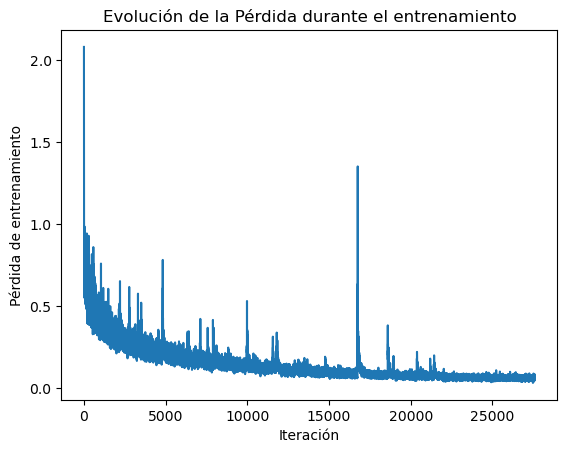

In [21]:
# Crear una figura y un eje
fig, ax = plt.subplots()

# Dibujamos las perdidas
ax.plot(total_losses)

# Añadimos el título y las etiquetas de los ejes
ax.set_title('Evolución de la Pérdida durante el entrenamiento')
ax.set_xlabel('Iteración')
ax.set_ylabel('Pérdida de entrenamiento')

plt.savefig('metrics/loss_train/best_model_results.png')

# Mostrar la gráfica
plt.show()

## Evolución Learning Rate

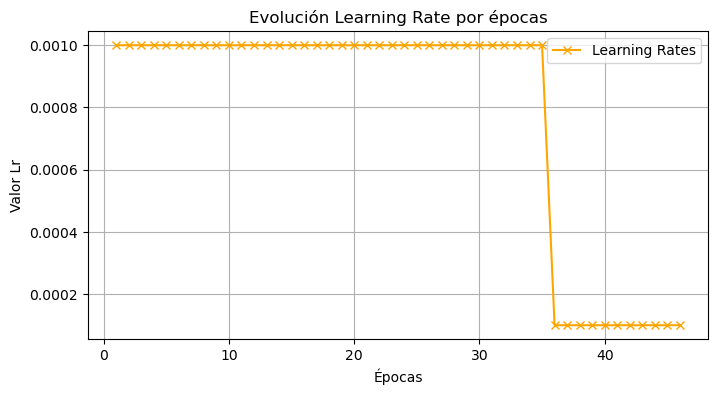

In [24]:
# Número de épocas
epocas = range(1, cont_epochs)
    
# Crear el gráfico
plt.figure(figsize=(8, 4))
plt.plot(epocas, learning_rates, label='Learning Rates', marker='x', linestyle='-', color="#FFA500")

# Etiquetas y título
plt.xlabel('Épocas')
plt.ylabel('Valor Lr')
plt.title('Evolución Learning Rate por épocas')
plt.legend()

# Mostrar el gráfico
plt.grid(True)
plt.savefig('metrics/lrs/best_model_results.png')
plt.show()

## Evolución acc para train y test

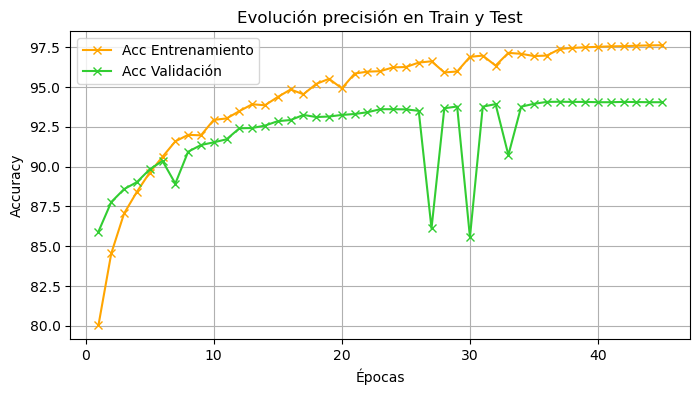

In [35]:
# Número de épocas
epocas = range(1, cont_epochs)

    
# Crear el gráfico
plt.figure(figsize=(8, 4))
plt.plot(epocas, train_acc, label='Acc Entrenamiento', marker='x', linestyle='-', color="#FFA500")
plt.plot(epocas, test_acc, label='Acc Validación', marker='x', linestyle='-', color="#32CD32")

# Etiquetas y título
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.title('Evolución precisión en Train y Test')
plt.legend()

# Mostrar el gráfico
plt.grid(True)
plt.savefig('metrics/train_test/best_model_results.png')
plt.show()

# ~~~~~~~~~~~~~~~~~~~~~ FIN DEL ENTRENAMIENTO ~~~~~~~~~~~~~~~~~~~~~

## Cargamos el modelo para observar los resultados

In [27]:
# Ruta a donde se encuentra el modelo
ruta_modelo = "models/best_model_results.pth"

# Cargamos el modelo (en este caso el que tiene los mejores resultados)
modelo = torch.load(ruta_modelo, map_location=torch.device('cpu'))

## Probabilidades predichas por el modelo

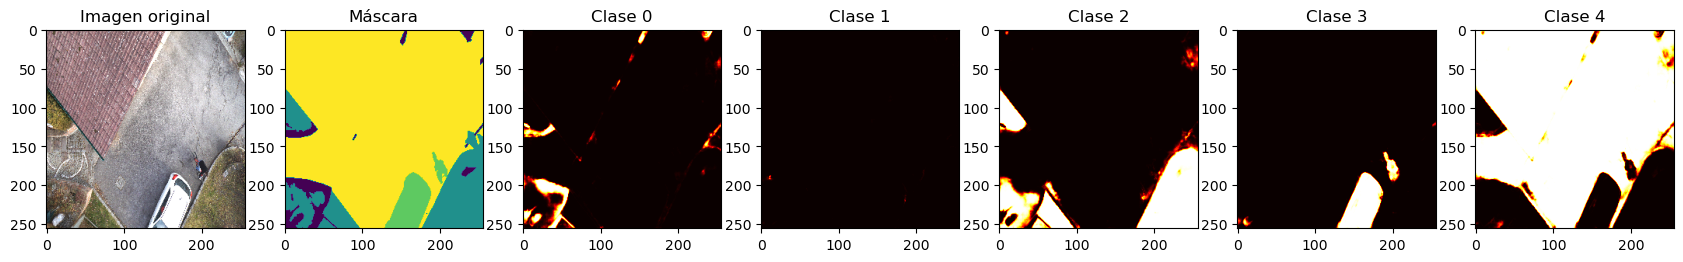

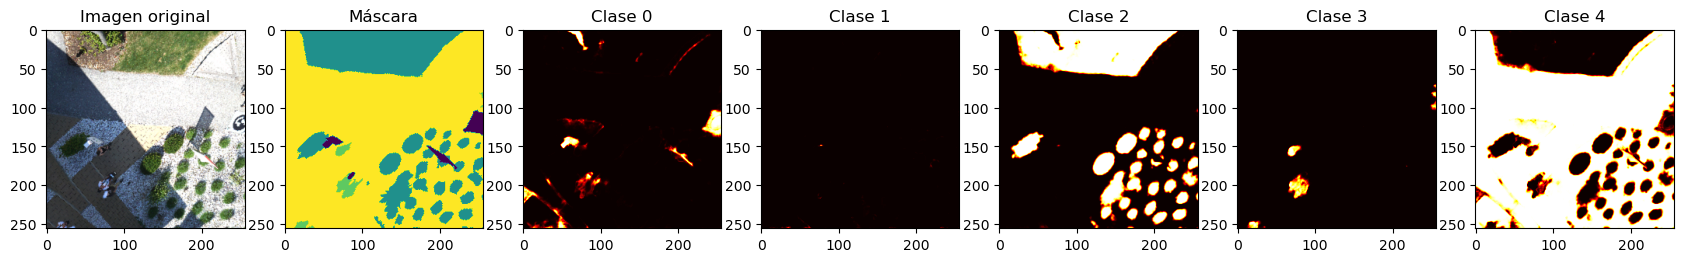

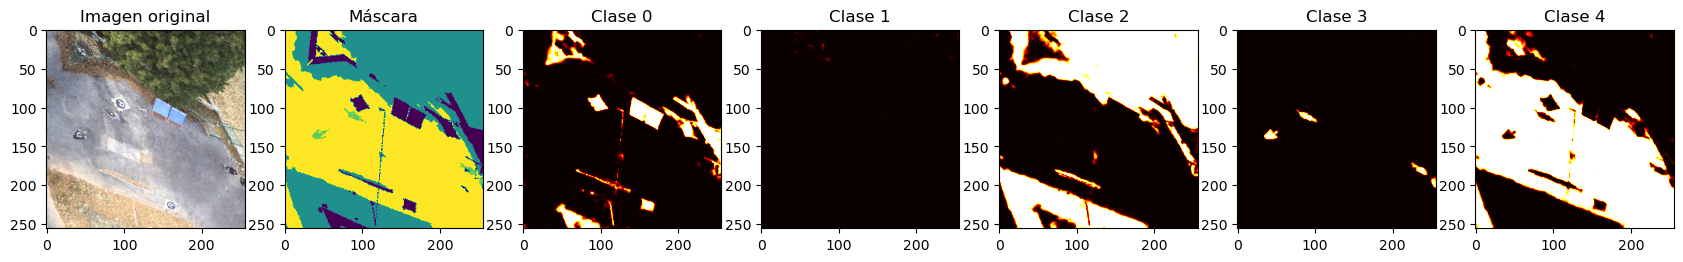

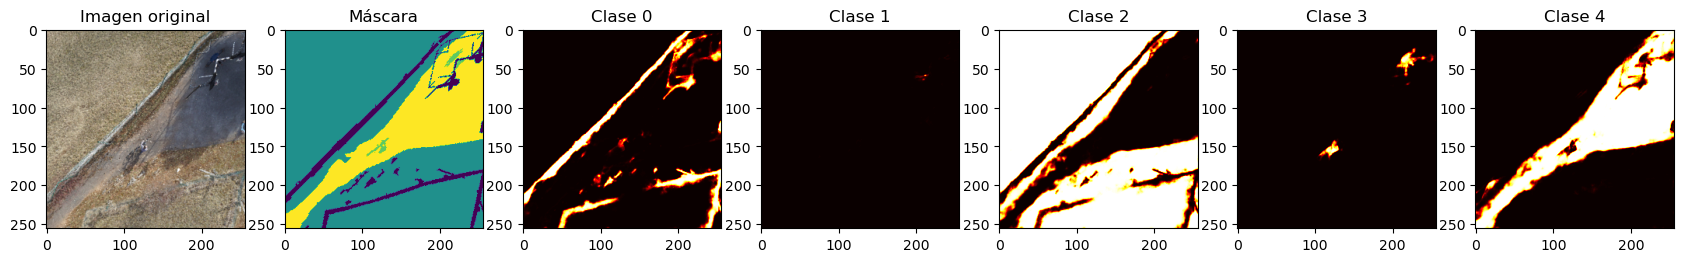

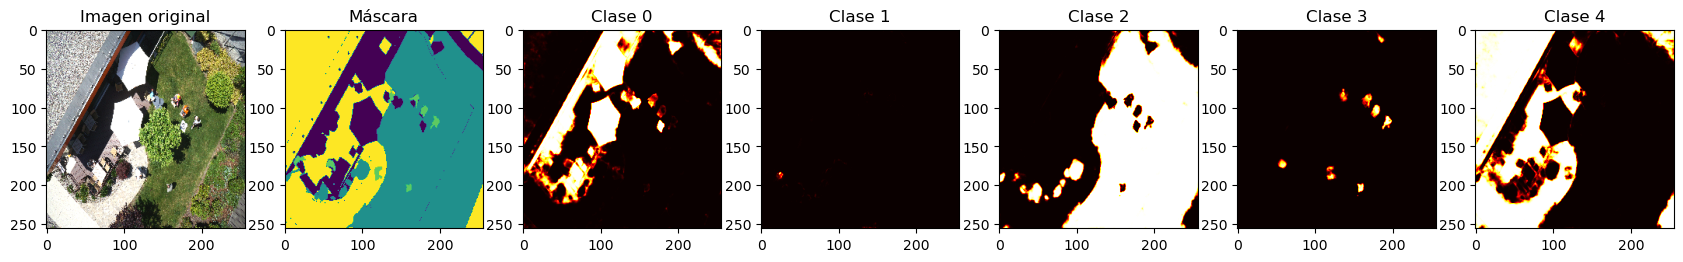

In [28]:
# Ponemos el modelo en modo evaluación
modelo.eval()

cont = 0

# Recorre las imágenes en el conjunto de datos de prueba
for batch_idx, (imagenes, mascaras) in enumerate(test_loader):

    # Permutamos para que sirva de entrada al modelo
    imagenes = imagenes.permute(0, 3, 1, 2)
    
    # Permutamos para poder mostrar la imagen original
    imagen_original = imagenes.permute(0, 2, 3, 1)
    
    # Movemos al device
    imagenes = imagenes.to(device, dtype=torch.float)
    mascaras = mascaras.to(device, dtype=torch.long)
        
    # Realiza la predicción
    with torch.no_grad():
        outputs = modelo(imagenes)
        
    # Aplica la función softmax para obtener las probabilidades
    probabilities = torch.softmax(outputs, dim=1)
    
    # Crea una figura con subplots en una sola fila, con 7 columnas
    fig, axs = plt.subplots(1, 7, figsize=(21, 3)) 

    # Muestra la imagen original
    axs[0].imshow(imagen_original[0].cpu().numpy())
    axs[0].set_title("Imagen original")

    # Muestra la máscara
    axs[1].imshow(mascaras[0].cpu().numpy())
    axs[1].set_title("Máscara")

    # Muestra las probabilidades para cada clase
    for i in range(5):
        axs[i+2].imshow(probabilities[0, i].cpu().numpy(), cmap='hot')
        axs[i+2].set_title(f"Clase {i}")
        
    cont += 1
    
    # Muestra unicamente 5 imágenes
    if cont == 5:
        break
        
    # Muestra la figura
    plt.show()

## Calculamos las métricas para los umbrales por lote

In [38]:
metrics = build_metrics_(modelo, test_loader)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [1:22:14<00:00, 24.67s/it]


## Media de las metricas de todos los lotes

In [39]:
average_metrics = mean_metrics(metrics)

## Imprimimos las métricas obtenidas

In [40]:
print_metrics(average_metrics, clases)

\Resultados para la clase Obstáculos:

    Threshold  Sensibilidad  Especificidad  Precision
0         0.0       1.00000        0.00000    0.09047
1         0.1       0.82293        0.95740    0.65633
2         0.2       0.78199        0.96938    0.71605
3         0.3       0.74954        0.97598    0.75478
4         0.4       0.71972        0.98054    0.78467
5         0.5       0.69040        0.98400    0.80938
6         0.6       0.65996        0.98681    0.83105
7         0.7       0.62608        0.98927    0.85135
8         0.8       0.58452        0.99157    0.87172
9         0.9       0.52309        0.99399    0.89483
10        1.0       0.00000        1.00000    0.00000
\Resultados para la clase Agua:

    Threshold  Sensibilidad  Especificidad  Precision
0         0.0       0.99000        0.00000    0.03021
1         0.1       0.97373        0.99760    0.91152
2         0.2       0.96875        0.99812    0.92688
3         0.3       0.96403        0.99844    0.93620
4         

## Almacenamos las métricas calculadas

In [41]:
import json

# Guardar el diccionario en un archivo .txt
with open('metrics/metrics/best_model_results.txt', 'w') as file:
    json.dump(average_metrics, file)

print("El diccionario se ha guardado!!")

El diccionario se ha guardado!!


## Dibujamos las curvas ROC

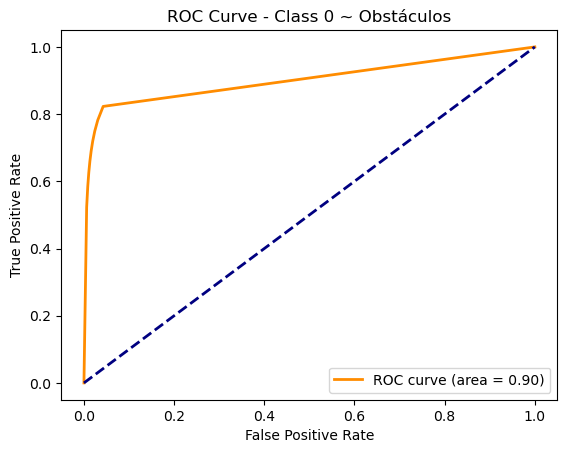

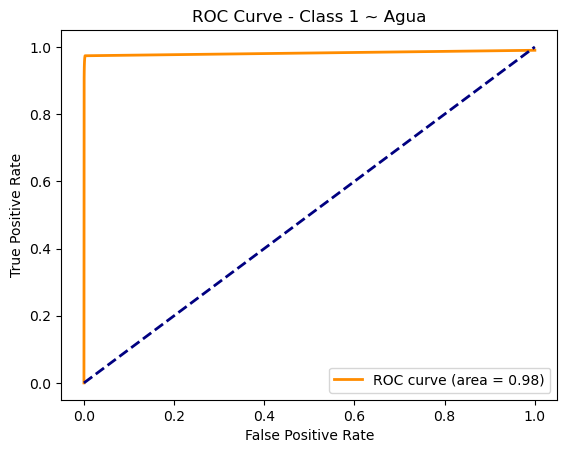

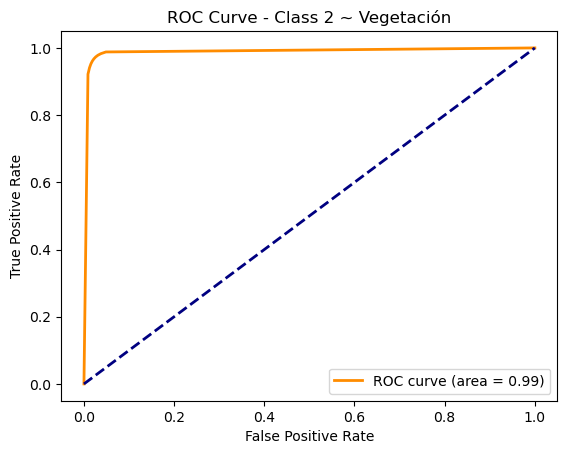

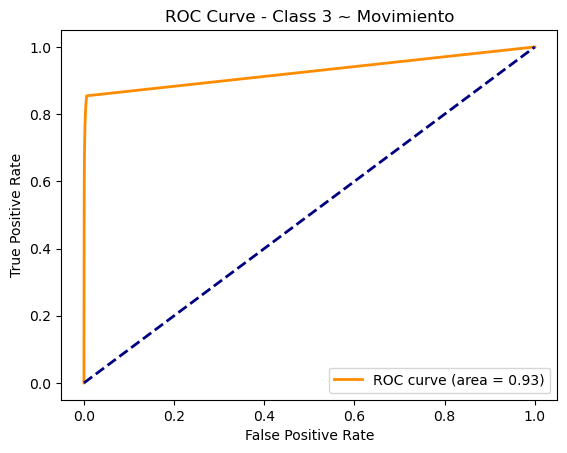

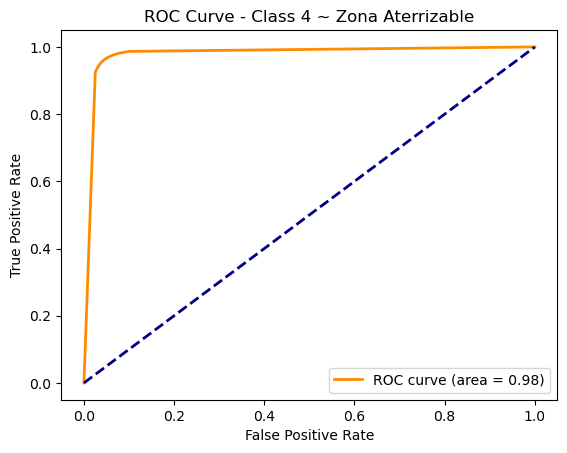

In [42]:
print_roc_curve(average_metrics, clases)

# ~~~~~~~~~~~~ EJEMPLO POSTPROCESAMIENTO IMAGEN ~~~~~~~~~~~~

## Ejemplo para aplicar la binarización y en caso de múltiple valor del píxel elegir el de mayor probabilidad

Comprobamos las dimensiones de los tensores
torch.Size([256, 256, 3])
torch.Size([256, 256])


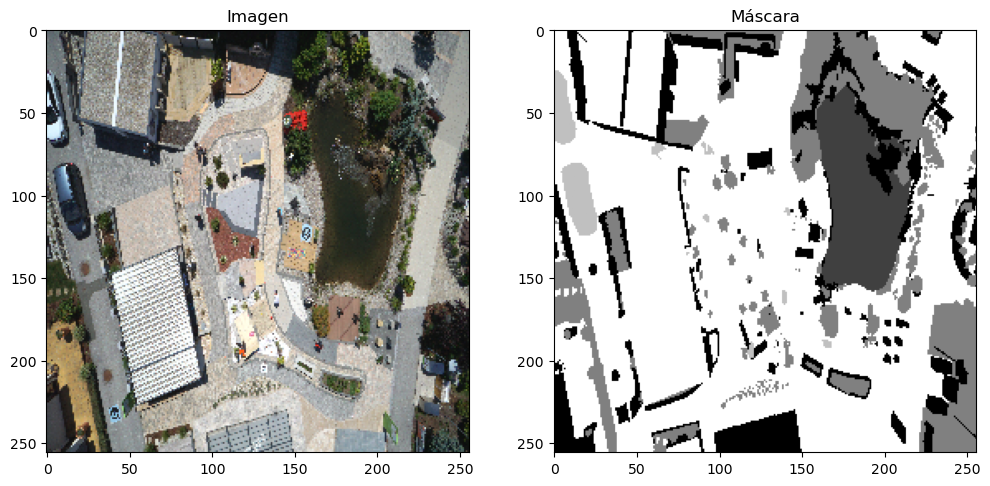

In [33]:
# Obtén el primer lote de datos del cargador de datos de entrenamiento
imagenes, mascaras = next(iter(test_loader))

# Selecciona la primera imagen y máscara del lote
imagen = imagenes[0]
mascara = mascaras[0]

print("Comprobamos las dimensiones de los tensores")
print(imagen.size())
print(mascara.size())

# Ahora puedes visualizar la imagen y la máscara con imshow()
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(imagen)
plt.title('Imagen')
plt.subplot(1, 2, 2)
plt.imshow(mascara, cmap='gray')
plt.title('Máscara')
plt.show()

## Comprobamos que las imagenes RGB estan escaladas en el rango [0-1]

In [34]:
print("El valor minimo que encontramos en la imagen RGB es: ",round(torch.min(imagen).item(),4), " y el valor máximo es: ",round(torch.max(imagen).item(),4))

El valor minimo que encontramos en la imagen RGB es:  0.0392  y el valor máximo es:  1.0


## Comprobamos los valores de las máscaras

In [35]:
print("Los distintos valores que encontramos en Ground Truth  son: ",np.unique(mascara))

Los distintos valores que encontramos en Ground Truth  son:  [0 1 2 3 4]


## Simulamos como funcionaria para una imagen - APP

In [36]:
# Eliminamos la dimension
imagen_carga = imagen.unsqueeze(0)
imagen_carga.size()

torch.Size([1, 256, 256, 3])

In [37]:
device = "cpu"

In [38]:
# La permuamos para que pueda ser procesada
imagen_carga = imagen_carga.permute(0, 3, 1, 2)
imagen_carga = imagen_carga.to(device, dtype=torch.float)

In [39]:
modelo.eval()
outputs = modelo(imagen_carga)
# Hallamos las probabilidades de predccion para esa imagen
outputs = torch.nn.functional.softmax(outputs, dim=1)

In [40]:
outputs.size()

torch.Size([1, 5, 256, 256])

Tenemos 4 dimensiones, 1 porque tiene 1 lote, 5 por las 5 clases, y 256x256 la resolución de las imágenes.

# -----------------------------------------

In [41]:
# Umbrales optimos para la binarización para el modelo
thresholds = [0.5, 0.5, 0.5, 0.5, 0.5] 

In [52]:
# Binarización de los mapas de probabilidad, creamos un tensor con la misma forma que la salida [1,5,256,256] 
binary_maps = torch.zeros_like(outputs)

# Creamos un tensor para almacenar las probabilidades máximas
# Es decir, elige el indice del plano que tiene la probabilidad mas alta, sobre la dimension 1,es decir, el 5
# max_classes entonces es un tensor de una dimension de indices, donde coincide el indice del plano de la probabilidad mas alta, con la clase correspondiente
_ , max_classes = torch.max(outputs, dim=1)

print("\nLas dimension de max_classes son: ", max_classes.size())

for i in range(outputs.size(1)):
    
    # Transformamos los tensores, de todo 0 a, 1's donde se supera el umbral y 0's donde no
    binary_map = (outputs[:, i, :, :] > thresholds[i]).float()
    
    # Aplicamos la clase de mayor probabilidad obtenida en max_classes
    # Para cada una de las clases generamos el mapa binarizado, pero ahora los pixeles tienen 0's o 1
    binary_maps[:, i, :, :] = binary_map * (max_classes == i).float()


Las dimension de max_classes son:  torch.Size([1, 256, 256])


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.]]])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 

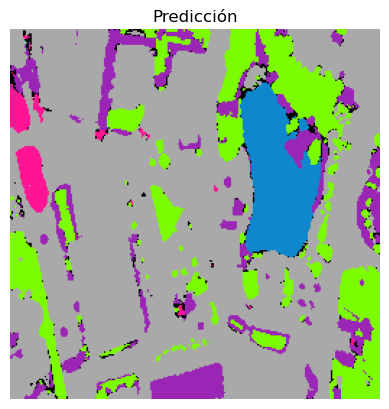

In [55]:
# Inicializa un tensor de salida para la imagen final, tiene que ser RGB, y del tamaño del output generado
final_image = torch.zeros((1, 3, outputs.size(2), outputs.size(3)))
final_image = final_image.to(device)

# Recorremos las claves del diccionario de colores
for class_idx in class_colors:
    
    # Creamos un tensor que actua de máscara para cada color
    class_mask = (binary_maps[:, class_idx, :, :] == 1).float()
    
    # Transforma cada color a un tensor de pytorch, normalizando
    color = torch.tensor(class_colors[class_idx], dtype=torch.float32) / 255.0
    color = color.to(device, dtype=torch.float)
    
    # Cambiamos la forma del tensor
    color = color.view(1, 3, 1, 1)
    
    # class_mask*color permite uqe los pixeles que pertencen a la clase tengan el color correspondiente, y 0 en el resto
    # En cada ejecución del bucle se suma un nuevo plano, se hace porque son excluyentes unos de otros, 
    # y un mismo pixel unicamente puede tomar un valor
    final_image += class_mask * color

# Convertimso el tensor a un arreglo NumPy y muestra la imagen
final_image_np = final_image.squeeze().cpu().numpy()
plt.imshow(final_image_np.transpose(1, 2, 0))
plt.axis('off')
plt.title("Predicción")
plt.show()

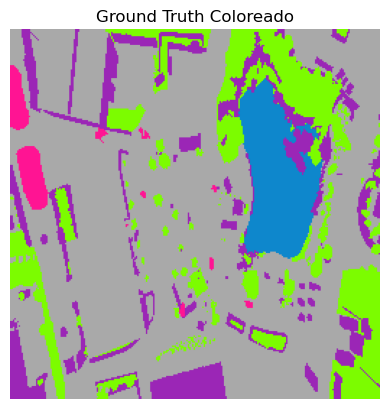

In [45]:
# Creamos un array para poder colorear la mascara
color_image = np.zeros((mascara.shape[0], mascara.shape[1], 3), dtype=np.uint8)

# Aplica el mapeo de colores
for key, value in class_colors.items():
    # Cada clase tiene asignado su color, por tanto vemos el valor que toma en la imagen y se corresponde con la clave del diccionario
    # Asignamos los colores necesarios
    color_image[mascara == key] = value

# Muestra la imagen
plt.imshow(color_image)
plt.axis('off')
plt.title("Ground Truth Coloreado")

plt.show()

## Clasificación correcta de los pixeles

In [46]:
final_image = final_image_np.transpose(1, 2, 0)

# Normaliza 'final_image' al rango 0-255
final_image_normalized = (final_image * 255).astype(np.uint8)

# Comprueba si los píxeles son iguales
pixels_igual = np.all(final_image_normalized == color_image, axis=-1)

# Calcula la precisión total
precision_clasificacion = np.sum(pixels_igual) / pixels_igual.size * 100

print(f'La precisión total es: {precision_clasificacion:.2f}%')

La precisión total es: 89.08%


## Proporción píxeles en negro

In [60]:
# Convierte la imagen a escala de grises
imagen_gris = final_image_np.mean(axis=0)

# Cuenta el número total de píxeles en la imagen
c

# Cuenta el número de píxeles negros en la imagen
pixeles_negros = np.sum(imagen_gris == 0)

print(f"El número de píxeles negros que se aprecian en la imagen: ", pixeles_negros)
print(f"El porcentaje de píxeles negros es: {round((pixeles_negros/total_pixeles)*100,2)}%")

El número de píxeles negros que se aprecian en la imagen:  1101
El porcentaje de píxeles negros es: 1.68%
